# Data Analysis Interview Challenge

## Part 1 ‐ Exploratory data analysis
****
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import datetime
import math
import json

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from IPython.core.display import display, HTML

In [2]:
logins = pd.read_json('data/logins.json', orient='columns')

logins['login_adj'] = logins['login_time'].dt.round('15min') # Round the login time to the nearest 15min

# extract each part of the datetime to get a simple overview of the data
logins['Year'] = logins['login_time'].dt.year
logins['Month'] = logins['login_time'].dt.month
logins['Day'] = logins['login_time'].dt.day_name()
logins['Time'] = logins['login_time'].dt.time
#logins['day_and_time'] = logins['Day'].astype(str) + ' ' + logins['Time'].astype(str)

#Find out what is in the data
print(logins['Year'].value_counts())
print(logins['Month'].value_counts())
print(logins['Day'].value_counts())
print(logins['login_adj'].min())
print(logins['login_adj'].max())

1970    93142
Name: Year, dtype: int64
3    33723
2    24673
1    21239
4    13507
Name: Month, dtype: int64
Saturday     19377
Sunday       18167
Friday       15208
Thursday     11960
Wednesday    10339
Tuesday       9268
Monday        8823
Name: Day, dtype: int64
1970-01-01 20:15:00
1970-04-13 19:00:00


First we note that Year is basicially vestigial as all entries are 1970. We also note that there are only the we stop at April 13th. Because we have a seemingly arbitrary range of time, in addition to one large time series dataframe, I will create one for each of the four months as well.

Now we will do the aggrigating.

In [3]:
logins_ts = logins.groupby('login_adj')
login_series = logins_ts['login_time'].count()

This data, aggregated every 15 minuntes, is very granular. So if we want to get a more readible plot for the whole dataset we will take the daily average of each 15 minute interval and plot that first.

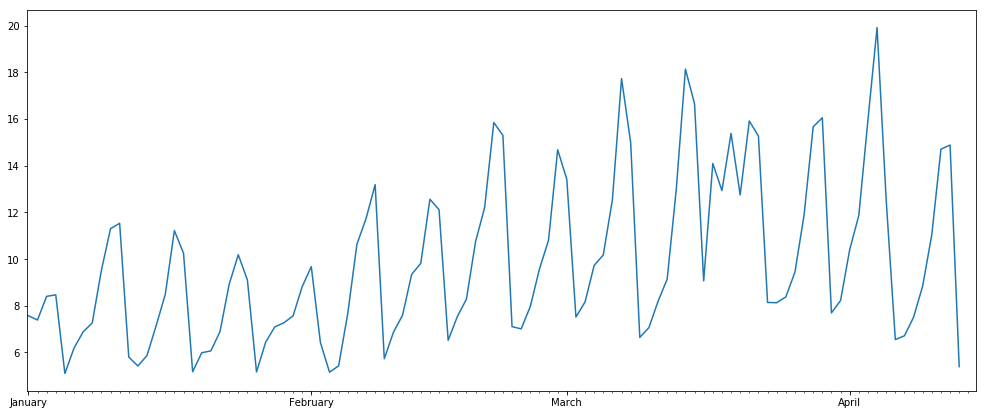

In [4]:
#The daily average of each 15 min interval, for ease of plotting
logins_days = login_series.groupby(login_series.index.date).mean()

days = mdates.DayLocator()   # every day
months = mdates.MonthLocator()  # every month
MonthsFmt = mdates.DateFormatter('%B')


fig, ax = plt.subplots(figsize = (17,7))
ax.plot(logins_days)

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(MonthsFmt)
ax.xaxis.set_minor_locator(days)

datemin = logins['login_adj'].min() - datetime.timedelta(days=1)
datemax = logins['login_adj'].max() + datetime.timedelta(days=1)
ax.set_xlim(datemin, datemax)

plt.show()

Here we can note a pretty obvious weekly pattern where the end of the week has a higher number of logins than the beginning. We also observe a gradual increase over time of logins.

There are a few curiosities to note as well. The first is that logins for January trend downward just a little bit, while logins for February trend upward considerably, while the logins for March are more constant.

Finaly, we note that the third week in March does not have the same pattern as the other weeks.

Next lets look at the weekly pattern. We'll start with a plot of the average for each 15 min interval. Then we can get a little more statistical with box and whisker plots. And the last plot will be inspired by climate change graphs with a different line plot for each week.

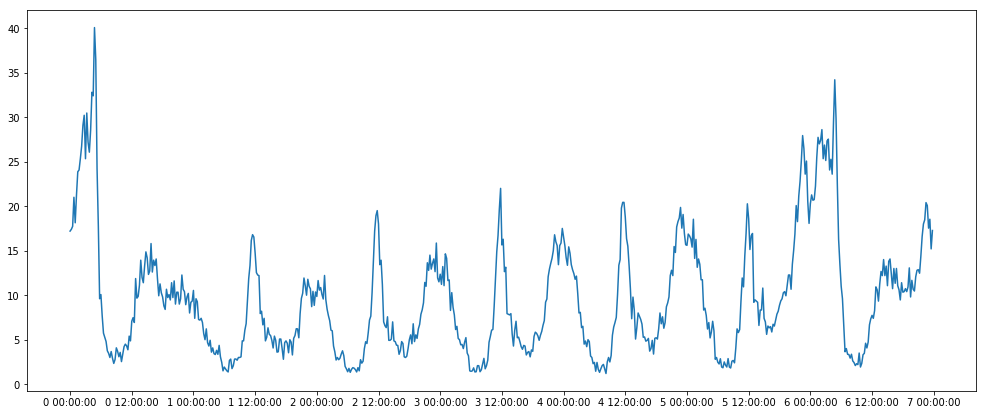

In [5]:
#login_series = login_weekly['login_time'].count()
#logins_2['day_and_time'] = logins_2['login_adj'].dt.day_name() + logins_2['login_adj'].dt.time
logins_2 = pd.DataFrame(logins.groupby('login_adj').count()['login_time'].reset_index())
logins_2['Weekday_int'] = logins_2['login_adj'].dt.strftime("%w")
logins_2['Weekday'] = logins_2['login_adj'].dt.strftime("%A")
logins_2['Time'] = logins_2['login_adj'].dt.time
logins_2['Day_and_Time'] = logins_2['Weekday_int'].astype(str)+ ' ' + logins_2['Time'].astype('str')

login_weekly = logins_2.groupby('Day_and_Time')
#login_weekly = logins_2.groupby(['Weekday_int', 'Time'])
weekly_series = login_weekly['login_time'].mean()

fig, ax = plt.subplots(figsize = (17,7))
ax.plot(weekly_series)
x_ticks = ['0 00:00:00', '0 12:00:00', '1 00:00:00', '1 12:00:00', '2 00:00:00', '2 12:00:00', 
           '3 00:00:00', '3 12:00:00', '4 00:00:00', '4 12:00:00', '5 00:00:00', '5 12:00:00',
           '6 00:00:00', '6 12:00:00', '7 00:00:00']

plt.xticks(x_ticks)

plt.show()

Here we can see the weekly and daily trend pretty well. We can see that during weekdays, logins are highest at midnight and at noon, while during the weekends are highest in the early morning shortly after midnight and lowest just before noon with consistent logins during the afternoon.

Furthermore, we have the most logins during the weekends.

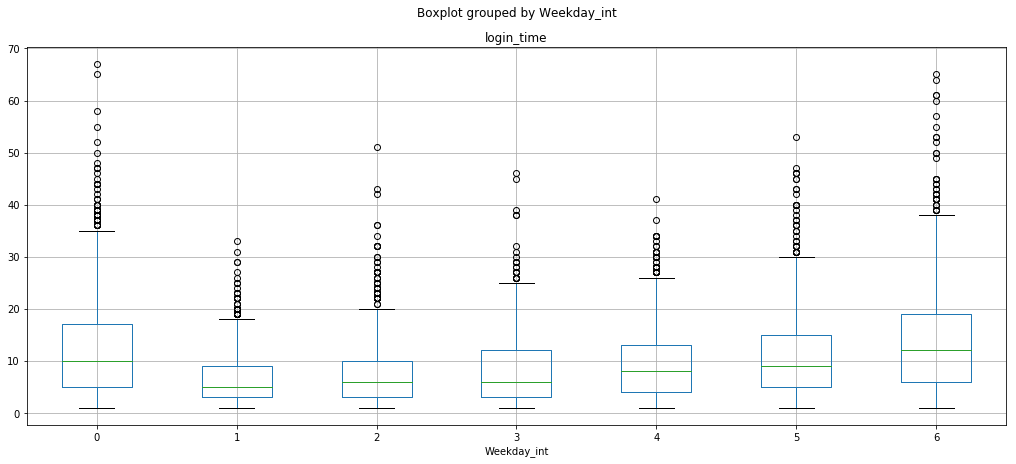

In [6]:
fig, ax = plt.subplots(figsize=(17,7))
plt.suptitle('')
logins_2.boxplot(column=['login_time'], by='Weekday_int', ax=ax)

In [7]:
#In order to make the next plot easier to see, we will take the average number of logins over the particular hour
#For instance, if the logins for 1970-01-01 20:00:00 until 21:00:00 are 4, 5, 7, 8 then we will record
# 6 for that hour as the average over that hour.
logins_2['Day_and_Hour'] = logins_2['login_adj'].dt.floor('H')
mean_hour = logins_2.groupby('Day_and_Hour')['login_time'].mean()
logins_3 = pd.DataFrame(mean_hour)
logins_3 = logins_3.reset_index()
logins_3['Week_Number'] = logins_3['Day_and_Hour'].dt.week
logins_3 = logins_3.set_index('Day_and_Hour')
pad_df = pd.DataFrame(pd.Series(pd.date_range(
    '1969-12-29 00:00:00', '1970-01-01 19:00:00', freq='H'))).rename(columns={0: 'Day_and_Hour'})
pad_df['login_time'] = 0
pad_df['Week_Number'] = 1
pad_df = pad_df.set_index('Day_and_Hour')
frames = [pad_df, logins_3]

logins_3 = pd.concat(frames)#.sort_index()
logins_3 = logins_3.reset_index()

In [8]:
logins_3['Day_and_Time'] = logins_3['Day_and_Hour'
                                   ].dt.strftime("%w").astype(str)+ ' ' + logins_3['Day_and_Hour'
                                                                                  ].dt.time.astype('str')

This confirms much of what we observed in the timeseries plot. And we can more clearly see that logins gradually increase throughout the week.

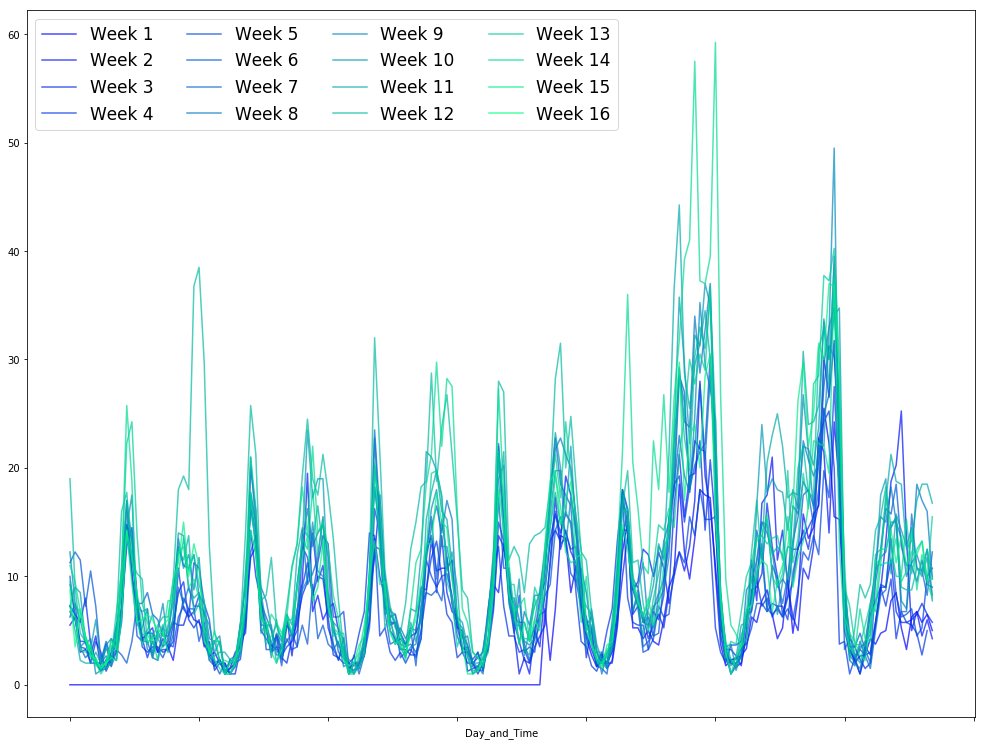

In [9]:
num_plots = len(logins_3['Week_Number'].unique())
plt.figure(figsize=(17,13))
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.winter(np.linspace(0, 1, num_plots))))

labels = []
for n in logins_3['Week_Number'].unique():
    one_week = logins_3[logins_3['Week_Number'] == n].set_index('Day_and_Time')['login_time']
    one_week.plot(alpha = 0.7)
    labels.append('Week ' + str(n))

plt.legend(labels, ncol=4, loc='upper left',  prop={'size': 17},
           fancybox=True)
plt.show()

Here we can see through colours how the weekly cycle increases over time. Lets now look at just the third week of March compared to the previous and subsequent weeks. Where we can see that the beginning of the third week in March had considerably higher logins than the weeks before and after, though the end of the week was similar. So we can assume there was some event in that week.

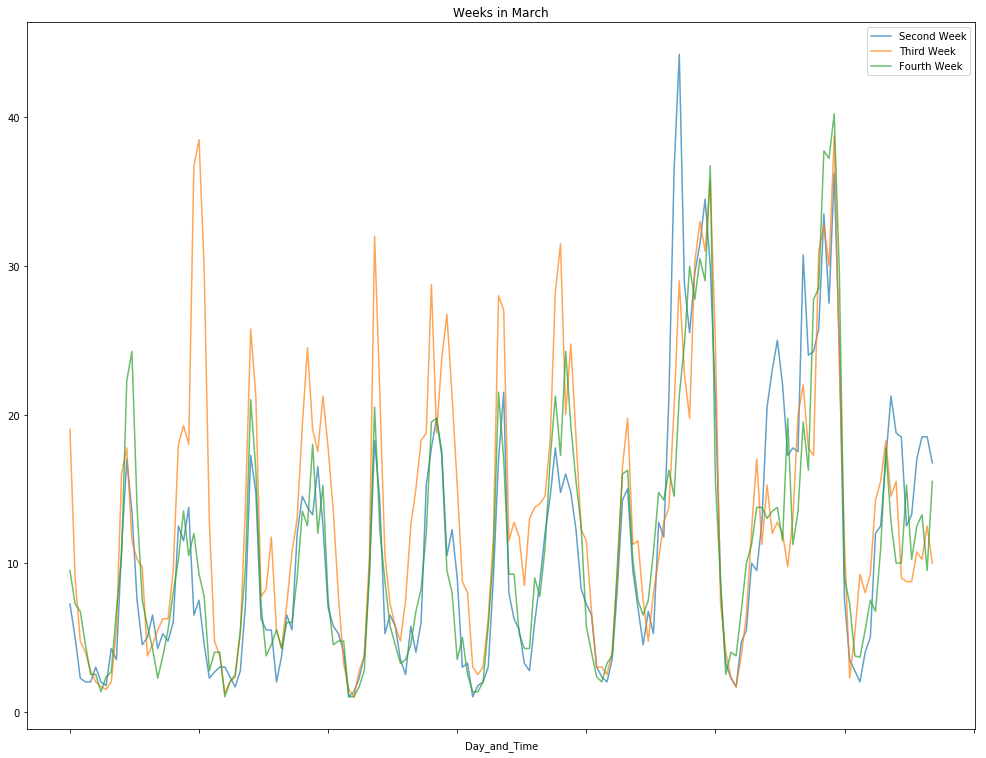

In [10]:
plt.figure(figsize=(17,13))

second_march = logins_3[logins_3['Week_Number'] == 11].set_index('Day_and_Time')['login_time']
second_march.plot(alpha = 0.7)
third_march = logins_3[logins_3['Week_Number'] == 12].set_index('Day_and_Time')['login_time']
third_march.plot(alpha = 0.7)
fourth_march = logins_3[logins_3['Week_Number'] == 13].set_index('Day_and_Time')['login_time']
fourth_march.plot(alpha = 0.7)
weeks = ['Second Week', 'Third Week', 'Fourth Week']
plt.title('Weeks in March')

plt.legend(weeks)
plt.show()

# Part 2 ‐ Experiment and metrics design
****
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
    * a. how you will implement the experiment
    * b. what statistical test(s) you will conduct to verify the significance of the observation
    * c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.


1) Since the primary reason for a partner to be exclusive to a particular city is the toll bridge, we should use crossing the toll bridge as the variable we measure, with a second variable as how many times toll reimbursements are issued. These will likely be closely correllated but probably not entirely.

We could observe timestamps for each time the toll bridge is crossed. Since the bridge is a two way toll bridge, partners may cross once and take many riders in the other city before returning. However, the reason for partners being exclusive was specifically given as the toll cost. Thus it is best to define success as an increased number of crossings as this represents a specific change in behaviour.

2) The variable we are measuring is simple enough to measure. We can do this by using GPS information from each car, as well as using data collected from the toll booths, depending on which is more easy to set up. The secondary variable is easy to observe as it is observed directly as crossings are reported.
    * a. The two ways of observing our variable can be investigated by looking into the viability of including software into the Ultimate GPS systems which record whenever the toll is crossed. This can be compared with the ease of accessing the data collected by the city toll booths on which cars cross and collect that data which is from Ultimate cars.
    
    It is also important to make observations prior to implementing the reimbursements. For this reason, gathering toll data from the city would allow Ultimate to proceed with reimbursements as soon as possible. Otherwise it may be necessary to delay the reimbursement program until after enough control data is collected.
    
    * b. Given how directly our variable relates to the question a simple hypothesis test would be sufficient to show if our experiment yields a positive result. We can also perform correlation tests to see what effect the secondary variable has.
    
    * c. If a positive result is observed it shows that the toll costs are discouraging people from crossing and doing business in the other city. If one or both of the two cities are interested in encouraging more cross-city business and a more integrated economy it may be worthwhile to set up a larger scale experiment to test if reducing or eliminating tolls spur economic growth. Though the scale and complexity of this experiment is larger than ours.

# Part 3 ‐ Predictive modeling
****
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import os
import json

In [15]:
with open('data/ultimate_data_challenge.json') as f:
   data = json.load(f)

users = pd.DataFrame(data)
users.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [16]:
users['last_trip_date'] = pd.to_datetime(users['last_trip_date'])
users['signup_date'] = pd.to_datetime(users['signup_date'])
print(users['last_trip_date'].min())
print(users['last_trip_date'].max())
print(len(users))

2014-01-01 00:00:00
2014-07-01 00:00:00
50000


We are, unfornately, not told when this data was pulled so we can instead note that the last trip date for the whole dataset is July 1st. So, since this dataset represents 50,000 people it is a reasonable assumption that one of them used the service the day it was pulled. So we take our pulled date as July 1st, 2014.
****
### Cleaning the dataset
So we will create our target variable, a boolean which is 1 if the last_trip_date occurred at most 30 days before July 1st, or after June 1st.

In [17]:
users['Active'] = abs(pd.to_datetime('2014-07-01') - pd.to_datetime(users['last_trip_date'])).dt.days < 30
# Changing Booleans to int
users['Active'] = users['Active'].astype(int)
users['ultimate_black_user'] = users['ultimate_black_user'].astype(int) 

# Changing strings to categorical int.
le = LabelEncoder()
users['city'] = le.fit_transform(users['city'])

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null int64
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null int64
weekday_pct               50000 non-null float64
Active                    50000 non-null int64
dtypes: datetime64[ns](2), float64(6), int64(4), object(1)
memory usage: 5.0+ MB


### Missing Values
****

Next, lets fill in a few missing values. For the missing ratings, we note that many ratings are quite high, in that case, let's simply replace missing values with the mean. As for the missing phone values, there are not very many and guessing them will be very difficult, as such, we will drop those entries with missing phone values.

We will also drop the datetime columns. We used last_trip_date to form our target variable, and signup is not likely to have a big effect as all are quite similar.

In [18]:
users['avg_rating_by_driver'].fillna((users['avg_rating_by_driver'].mean()), inplace=True)
users['avg_rating_of_driver'].fillna((users['avg_rating_of_driver'].mean()), inplace=True)
users = users.dropna()
users['phone'] = le.fit_transform(users['phone'])
users_num = users.drop(['last_trip_date', 'signup_date'], axis=1).copy()
users_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 11 columns):
avg_dist                  49604 non-null float64
avg_rating_by_driver      49604 non-null float64
avg_rating_of_driver      49604 non-null float64
avg_surge                 49604 non-null float64
city                      49604 non-null int64
phone                     49604 non-null int64
surge_pct                 49604 non-null float64
trips_in_first_30_days    49604 non-null int64
ultimate_black_user       49604 non-null int64
weekday_pct               49604 non-null float64
Active                    49604 non-null int64
dtypes: float64(6), int64(5)
memory usage: 4.5 MB


## Building the Model
****
We will start by geting a train/test split. Then use XgBoost to come up with a list of most useful features. After that we will train a number of classifiers. Random Forests are usually the best choice for simple classifications as they are quite accurate.

In [19]:
column_names = list(users_num)
features = column_names[:-1]

X_train, X_test, y_train, y_test = train_test_split(users_num[features], users_num['Active'])

[17:18:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=8
[17:18:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=8
[17:18:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=8
[17:18:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=8
[17:18:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=8
[17:18:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=8
[17:18:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=8
[17:18:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 442 extra nodes, 0 pruned nodes, max_depth=8
[17:18:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned no

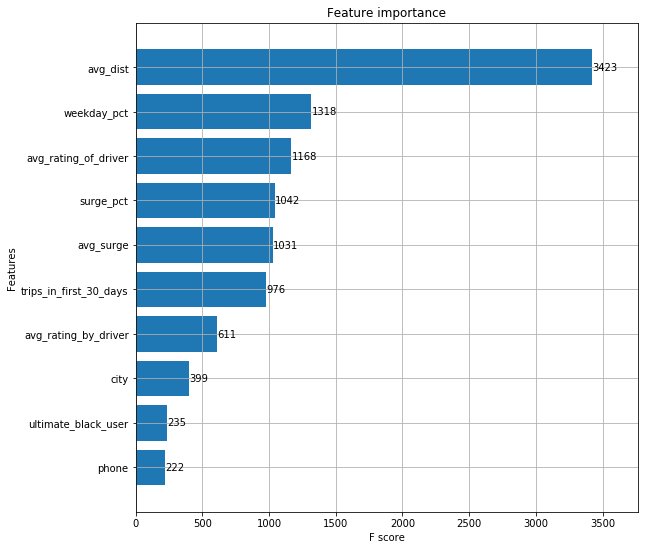

In [20]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

feat_names = np.array(features)

for c in X_train.columns:
    if X_train[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(X_train[c].values))
        df_train[c] = lbl.transform(list(X_train[c].values))

#import xgboost as xgb
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}
dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(9,9))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()


Here we can see that avg_rating_by_driver, city, ultimate_black_user and phone have very low importance.

### Random Forest Classifier

In [26]:
clf = RandomForestClassifier(n_estimators = 5, max_features = 4, random_state = 5)
clf.fit(X_train, y_train)
print('samples: 5, features: 4')
print('Accuracy of RF classifier on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}' .format(clf.score(X_test, y_test)))
print('')

samples: 5, features: 4
Accuracy of RF classifier on training set: 0.96
Accuracy of RF classifier on test set: 0.75



### Gradiant Boosting

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

learning_rates = [0.01, 0.05, 0.1]
depths = [2,3,5]

#best performance at 0.1 rate, depth 5 for 0.5 width

for i in learning_rates:
    for j in depths:
        clf_boost = GradientBoostingClassifier(learning_rate = i, max_depth = j, random_state = 5)
        clf_boost.fit(X_train, y_train)

        print('rate: ', i, ' depth: ',j)
        print('Accuracy of GBDT classifier on training set: {:.2f}'.format(clf_boost.score(X_train, y_train)))
        print('Accuracy of GBDT classifier on test set: {:.2f}'.format(clf_boost.score(X_test, y_test)))
        print('-')

rate:  0.01  depth:  2
Accuracy of GBDT classifier on training set: 0.72
Accuracy of GBDT classifier on test set: 0.72
-
rate:  0.01  depth:  3
Accuracy of GBDT classifier on training set: 0.75
Accuracy of GBDT classifier on test set: 0.75
-
rate:  0.01  depth:  5
Accuracy of GBDT classifier on training set: 0.77
Accuracy of GBDT classifier on test set: 0.77
-
rate:  0.05  depth:  2
Accuracy of GBDT classifier on training set: 0.78
Accuracy of GBDT classifier on test set: 0.78
-
rate:  0.05  depth:  3
Accuracy of GBDT classifier on training set: 0.79
Accuracy of GBDT classifier on test set: 0.79
-
rate:  0.05  depth:  5
Accuracy of GBDT classifier on training set: 0.80
Accuracy of GBDT classifier on test set: 0.79
-
rate:  0.1  depth:  2
Accuracy of GBDT classifier on training set: 0.79
Accuracy of GBDT classifier on test set: 0.79
-
rate:  0.1  depth:  3
Accuracy of GBDT classifier on training set: 0.79
Accuracy of GBDT classifier on test set: 0.79
-
rate:  0.1  depth:  5
Accuracy of 

### Naive Bayes Classifier

In [23]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf_NN = MLPClassifier(hidden_layer_sizes = [10, 10], alpha = 0.01,
                       random_state = 5, solver='lbfgs').fit(X_train_scaled, y_train)


print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf_NN.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf_NN.score(X_test_scaled, y_test)))

/Users/Eric/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Accuracy of NN classifier on training set: 0.77
Accuracy of NN classifier on test set: 0.77


## Choices
****
Here we can see that, through a number of popular classifiers, the best choice is a Gradiant Boosted decision tree with a learning rate of 0.1 and a depth of 5.
****
## Recommendations
****
Through the feature importance graph we can see which particular features Ultimate may want to focus on when targetting riders, and what to encourage. It also shows that the Ultimate Black program does not affect retention much.